In [1]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os
import csv
import pandas as pd

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/aerial-cactus-identification2.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall("/tmp")
zip_ref.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Library and Data


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
import os
os.getcwd()
# place the files in your IDE working dicrectory .
labels = pd.read_csv(r'/tmp/aerial-cactus-identification/train.csv')
submission = pd.read_csv(r'/tmp/aerial-cactus-identification/sample_submission.csv')

train_path = "/tmp/aerial-cactus-identification/train/"
test_path = "/tmp/aerial-cactus-identification/test/"

In [4]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
labels.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [6]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

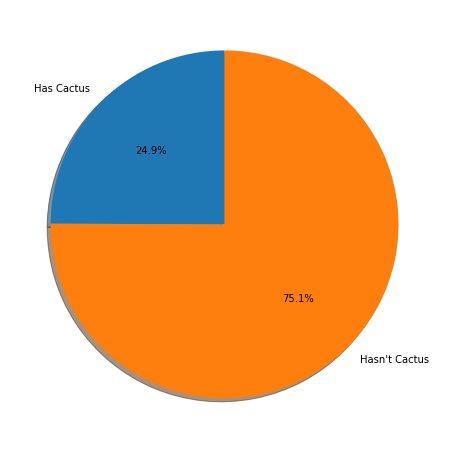

In [7]:
label = 'Has Cactus', 'Hasn\'t Cactus'
plt.figure(figsize = (8,8))
plt.pie(labels.groupby('has_cactus').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

Image Pre-processing


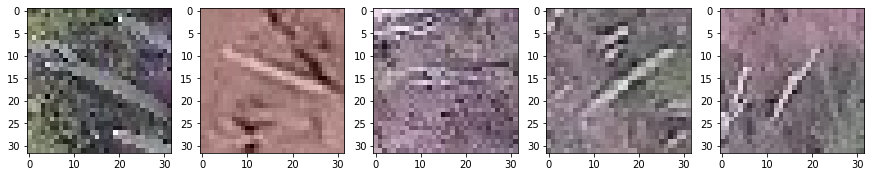

In [8]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['has_cactus'] == 1]['id'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

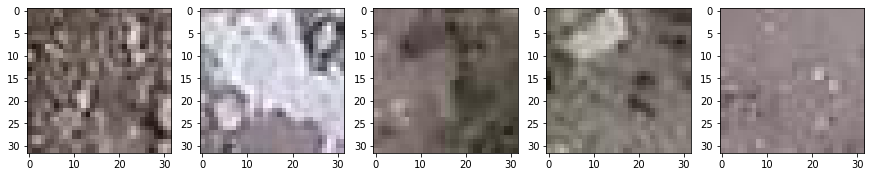

In [9]:
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(labels[labels['has_cactus'] == 0]['id'][:5]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [11]:
class CactiDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

Normalization

In [12]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])

Splitting the Dataset

In [13]:
train, valid_data = train_test_split(labels, stratify=labels.has_cactus, test_size=0.2)

In [14]:
train_data = CactiDataset(train, train_path, train_transform )
valid_data = CactiDataset(valid_data, train_path, valid_transform )
test_data = CactiDataset(submission, test_path, test_transform )

In [15]:
# Hyper parameters

num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.001

In [16]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [17]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size,shuffle=False, num_workers=0)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

training images
torch.Size([3, 32, 32])


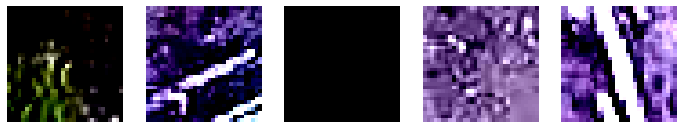

In [19]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

In [20]:
epochs = 35
batch_size = 25
learning_rate = 0.001

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=0, stride=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3,padding=0, stride=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [23]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [25]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [26]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.189200 	Validation Loss: 0.071636
Epoch: 2 	Training Loss: 0.094138 	Validation Loss: 0.054965
Epoch: 3 	Training Loss: 0.078825 	Validation Loss: 0.049467
Epoch: 4 	Training Loss: 0.068179 	Validation Loss: 0.064913
Epoch: 5 	Training Loss: 0.066476 	Validation Loss: 0.042952
Epoch: 6 	Training Loss: 0.055996 	Validation Loss: 0.060109
Epoch: 7 	Training Loss: 0.059444 	Validation Loss: 0.042675
Epoch: 8 	Training Loss: 0.055039 	Validation Loss: 0.039832
Epoch: 9 	Training Loss: 0.050248 	Validation Loss: 0.035387
Epoch: 10 	Training Loss: 0.049044 	Validation Loss: 0.041241
Epoch: 11 	Training Loss: 0.047537 	Validation Loss: 0.029610
Epoch: 12 	Training Loss: 0.043148 	Validation Loss: 0.031823
Epoch: 13 	Training Loss: 0.046091 	Validation Loss: 0.042566
Epoch: 14 	Training Loss: 0.043866 	Validation Loss: 0.032047
Epoch: 15 	Training Loss: 0.038227 	Validation Loss: 0.027124
Epoch: 16 	Training Loss: 0.039401 	Validation Loss: 0.033251
Epoch: 17 	Traini

In [27]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 99.17142857142858 %


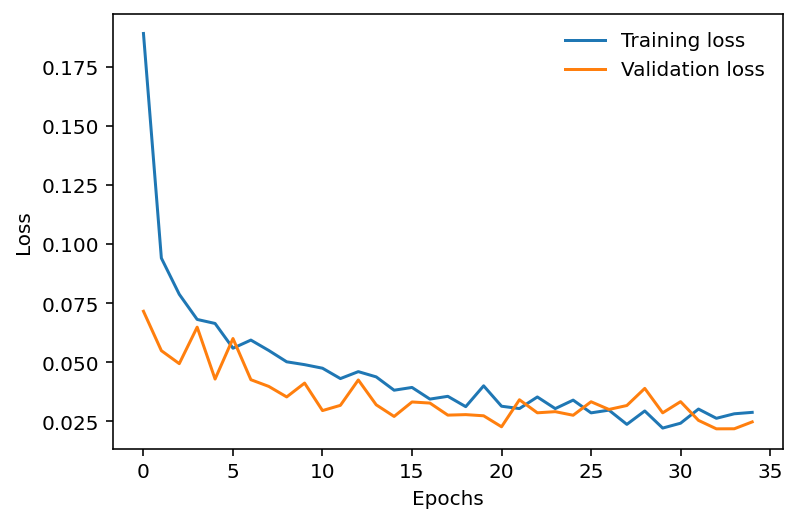

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [50]:
torch.save(model.state_dict(), 'model_cnn.pth')